<a href="https://colab.research.google.com/github/sameer203/Tensorflow_/blob/main/09_transfer_learning_tensorflow_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Tue Oct 26 16:57:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Getting the Data

In [3]:
# helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-10-26 16:58:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-26 16:58:33 (113 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2021-10-26 16:59:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.213.128, 173.194.216.128, 173.194.217.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.213.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   264MB/s    in 6.7s    

2021-10-26 16:59:26 (233 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [6]:
unzip_data("101_food_classes_10_percent.zip")

In [7]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/croque_madame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/frozen_yogurt'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_toast'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ravioli'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ceviche'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/shrimp_and_grits'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/waffles'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/falafel'.
There are 0 directories and 75 images in '101_fo

In [9]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [10]:
#set up input data
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [11]:
# Create a model checkpoint callback
checkpoint_path = "101_food_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only =False,
                                                         monitor="val_loss",
                                                         save_best_only=True)

In [14]:
# Data Agumentation Layer
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

In [16]:
data_agumentation = Sequential([
                                preprocessing.RandomFlip("horizontal"),
                                preprocessing.RandomRotation(0.2),
                                preprocessing.RandomHeight(0.2),
                                preprocessing.RandomWidth(0.2),
                                preprocessing.RandomZoom(0.2),
                                #preprocessing.Rescaling(1/255.)
], name="data_agumentation")

In [19]:
# Functional API for Efficient Net B0
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Set up model with trainable architecture
inputs = layers.Input(shape=(224, 224,3), name="input_layer")
x = data_agumentation(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D(name="Global_Averaging_2D")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)


In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_agumentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
Global_Averaging_2D (GlobalA (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [21]:
# Compile the model
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [23]:
# Fit the Model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15*(len(test_data))),
                                           callbacks=[checkpoint_callback]
)

Epoch 1/5
237/237 [==============================] - 57s 158ms/step - loss: 3.4754 - accuracy: 0.2420 - val_loss: 2.4892 - val_accuracy: 0.4285
INFO:tensorflow:Assets written to: 101_food_classes_10_percent_data_model_checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
237/237 [==============================] - 31s 131ms/step - loss: 2.3408 - accuracy: 0.4656 - val_loss: 2.0598 - val_accuracy: 0.4894
INFO:tensorflow:Assets written to: 101_food_classes_10_percent_data_model_checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/5
237/237 [==============================] - 30s 125ms/step - loss: 1.9820 - accuracy: 0.5246 - val_loss: 1.9140 - val_accuracy: 0.5106
INFO:tensorflow:Assets written to: 101_food_classes_10_percent_data_model_checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/5
237/237 [==============================] - 29s 119ms/step - loss: 1.7595 - accuracy: 0.5760 - val_loss: 1.8448 - val_accuracy: 0.5215
INFO:tensorflow:Assets written to: 101_food_classes_10_percent_data_model_checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/5
237/237 [==============================] - 28s 114ms/step - loss: 1.6048 - accuracy: 0.6091 - val_loss: 1.7884 - val_accuracy: 0.5347
INFO:tensorflow:Assets written to: 101_food_classes_10_percent_data_model_checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [25]:
fine_tuning_result= model.evaluate(test_data)
fine_tuning_result

790/790 [==============================] - 52s 66ms/step - loss: 1.7366 - accuracy: 0.5478


[1.7365708351135254, 0.547762393951416]

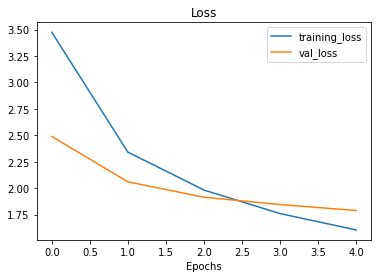

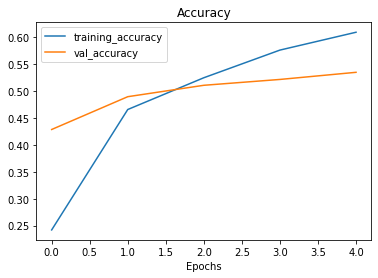

In [27]:
plot_loss_curves(history_all_classes_10_percent)

### Fine tuning

In [26]:
# unfreezing layers
base_model.trainable= True

# Refreeze the layer
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [28]:
# recompile the mode
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [30]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_agumentation True
efficientnetb0 True
Global_Averaging_2D True
output_layer True


In [31]:
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [33]:
fine_tune_epoch = 10

In [34]:
#Refit the Model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                           epochs= fine_tune_epoch,
                                           validation_data=test_data,
                                           validation_steps=int(0.15*(len(test_data))),
                                           initial_epoch=history_all_classes_10_percent.epoch[-1]
)

Epoch 5/10
237/237 [==============================] - 35s 121ms/step - loss: 1.3604 - accuracy: 0.6474 - val_loss: 1.7042 - val_accuracy: 0.5471
Epoch 6/10
237/237 [==============================] - 27s 113ms/step - loss: 1.2386 - accuracy: 0.6671 - val_loss: 1.6992 - val_accuracy: 0.5477
Epoch 7/10
237/237 [==============================] - 26s 109ms/step - loss: 1.1545 - accuracy: 0.6899 - val_loss: 1.6914 - val_accuracy: 0.5532
Epoch 8/10
237/237 [==============================] - 26s 108ms/step - loss: 1.0794 - accuracy: 0.7162 - val_loss: 1.6835 - val_accuracy: 0.5622
Epoch 9/10
237/237 [==============================] - 26s 108ms/step - loss: 1.0238 - accuracy: 0.7294 - val_loss: 1.7011 - val_accuracy: 0.5564
Epoch 10/10
237/237 [==============================] - 26s 107ms/step - loss: 0.9737 - accuracy: 0.7398 - val_loss: 1.6812 - val_accuracy: 0.5585


In [35]:
history_all_classes_10_percent_fine_tune_results = model.evaluate(test_data)

790/790 [==============================] - 55s 69ms/step - loss: 1.6212 - accuracy: 0.5763


In [36]:
history_all_classes_10_percent_fine_tune_results

[1.6211655139923096, 0.5763168334960938]

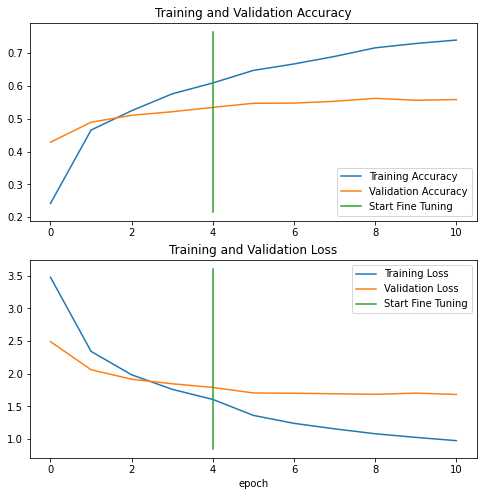

In [37]:
compare_historys(history_all_classes_10_percent, history_all_classes_10_percent_fine_tune)

In [38]:
# saving and loading the model
model.save("101_food_classes_10_percent_model_fine_tuned.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [39]:
loaded_model = tf.keras.models.load_model("101_food_classes_10_percent_model_fine_tuned.h5")

In [40]:
loaded_model_result = loaded_model.evaluate(test_data)
loaded_model_result

790/790 [==============================] - 54s 67ms/step - loss: 2.1187 - accuracy: 0.4652


[2.1186633110046387, 0.46522772312164307]

In [41]:
history_all_classes_10_percent_fine_tune_results

[1.6211655139923096, 0.5763168334960938]

### Evaluating the performance of the model

In [42]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2021-10-26 18:06:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.139.128, 173.194.211.128, 173.194.215.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.139.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  71.6MB/s    in 0.6s    

2021-10-26 18:06:41 (71.6 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [43]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [44]:
# Load in the pretrained models
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [45]:
# Evaluate loaded model
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 54s 67ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027223348617554, 0.6077623963356018]